In [100]:
import copy
import numpy as np
import laspy as lp
import pyvista as pv
import pandas as pd

def view_cloud_pv(points):
    xyz = points[:, :3]  # Primeras 3 columnas: X, Y, Z
    rgb = points[:, 3:6]  # Columnas 4-6: R, G, B
    
    # Normalizar RGB de 16-bit (LAS) a 8-bit (0-255)
    if np.issubdtype(rgb.dtype, np.integer) and rgb.max() > 255:
        rgb = (rgb // 256).astype(np.uint8)  # Conversión a 8-bit
    
    # Crear objeto PolyData con coordenadas
    cloud = pv.PolyData(xyz)
    
    # Añadir colores RGB como array asociado a los puntos
    cloud["RGB"] = rgb.astype(np.uint8)  # Asegurar tipo uint8
    
    # Configurar plotter
    plotter = pv.Plotter()
    plotter.add_mesh(
        cloud,
        scalars="RGB",  # Usar el array RGB
        rgb=True,       # Indicar que son canales RGB
        point_size=3,   # Tamaño de los puntos
        opacity=1       # Opacidad total
    )
    
    plotter.show()

def generate_dem(points, rasante, grid_spacing=None):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    #z = np.clip(z, -0.01, 4)
    print(z[z < 0].shape)
    # Calcular espaciado de la grilla
    if grid_spacing is None:
        dx = np.diff(x)
        dy = np.diff(y)
        point_spacing = np.mean(np.sqrt(dx**2 + dy**2))
        grid_spacing = point_spacing
    
    print(grid_spacing)
    # Crear dimensiones de la grilla
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan

    return dem

def get_points(path, salmuera):
    las = lp.read(path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.intensity, -1),
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))
    
    single = data_points[data_points[:, -1] == 1][:, :6]  #XYZRGB
    second = data_points[(data_points[:, -1] == 2) & (data_points[:, -1] == 2)][:, :6]
    mask_second = second[:,2] < salmuera
    second = second[mask_second]

    return np.vstack((single, second))

def get_roi(points, p=0.05):
    # Obtener límites originales
    x_min = np.min(points[:, 0])
    x_max = np.max(points[:, 0])
    y_min = np.min(points[:, 1])
    y_max = np.max(points[:, 1])
    
    # Calcular 5% del largo de cada eje
    x_offset = p * (x_max - x_min)
    y_offset = p * (y_max - y_min)
    
    # Ajustar límites hacia adentro
    new_x_min = x_min + x_offset
    new_x_max = x_max - x_offset
    new_y_min = y_min + y_offset
    new_y_max = y_max - y_offset
    
    return new_x_min, new_x_max, new_y_min, new_y_max

In [107]:
df = pd.read_csv('data/vuelos/data_sqm.csv')

POZAS = {}

for index, row in df.iterrows():
    fecha = row['Fecha']
    poza = row['Poza'].replace('-','').lower()
    rasante = row['Rasante (m)']
    cota_salm = row['Cota Salm. (m)']
    cota_sal = row['Cota Sal (m)']
    sal = row['Sal (cm)']
    salmuera = row['Salmuera (cm)']

    if poza not in POZAS:
        POZAS[poza] = {}

    POZAS[poza][fecha] = {
        'Rasante (m)': rasante,
        'Cota Salmuera sqm (m)': cota_salm,
        'Cota Sal sqm (m)': cota_sal,
        'Sal sqm (cm)': sal,
        'Salmuera sqm (cm)': salmuera
    }

POZA = '7a'
DATE = '04_01_2025'
H = '100'
V = '10'
F = '100'
PATH_LAS = f'data/vuelos/{DATE}/{H}m_{V}ms_{F}khz/{POZA}_{H}m_{V}ms_{F}khz.las'
PDATA = POZAS.get(POZA).get(f'{DATE.replace("_","/")}')
RASANTE = PDATA.get('Rasante (m)')
SALMUERA = PDATA.get('Cota Salmuera sqm (m)')

print(f'Poza: {PATH_LAS}')
SALMUERA

Poza: data/vuelos/04_01_2025/100m_10ms_100khz/7a_100m_10ms_100khz.las


2301.194

In [108]:
points = get_points(PATH_LAS, SALMUERA)
print(points.shape)
x_min, x_max, y_min, y_max = get_roi(points)
mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
       (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
roi_points = points[mask]
#print(roi_points.shape)
#view_cloud_pv(points)
#view_cloud_pv(roi_points)

dem = generate_dem(roi_points, RASANTE)

(13706796, 6)
(3586878,)
0.21701039588483226


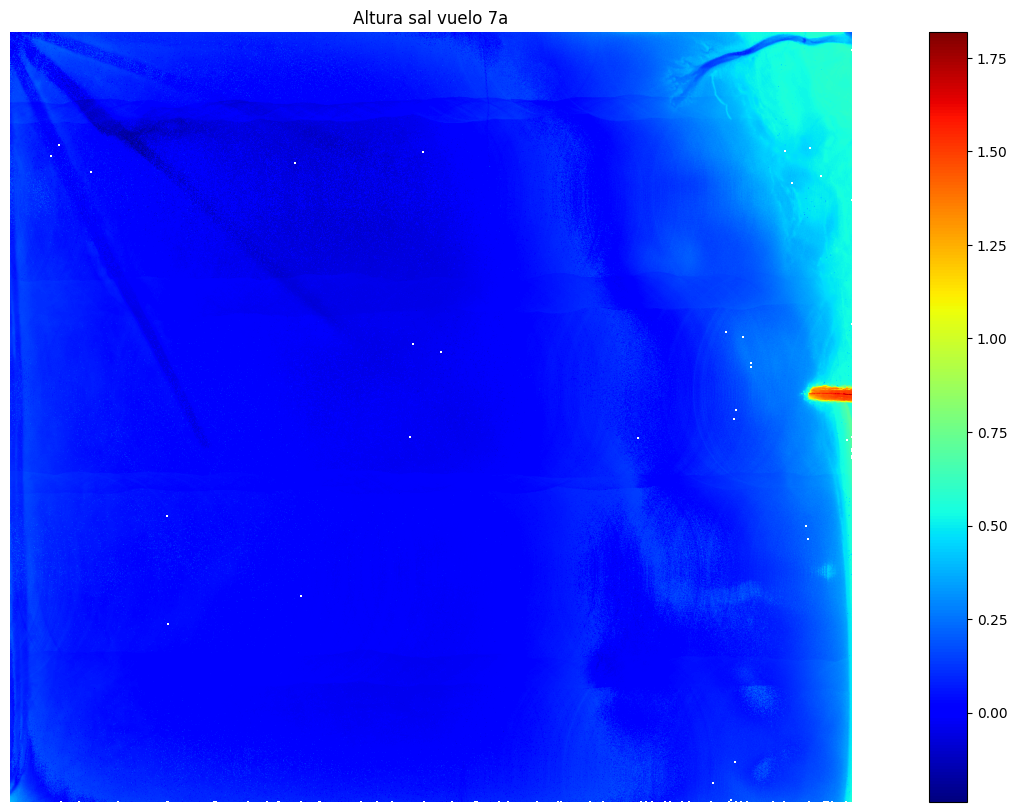

In [109]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(dem, cmap='jet')
plt.colorbar()
plt.title(f'Altura sal vuelo {POZA}')  
plt.axis('off')
plt.show()